In [345]:
import matlab.engine
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io

In [106]:
from datetime import datetime

In [ ]:
!pip install pandas

In [ ]:
!pip install %matplotlibtlib

In [ ]:
!pip install psycopg2

In [ ]:
!pip install scipy

In [44]:
# library to connect postgres with python
import psycopg2

In [489]:
# making a connection
## todo _ get the credentials from config file
conn = psycopg2.connect(user='test2', password='123wer', host='192.168.142.73', dbname='test2db')

# get the cursor from connection
cur = conn.cursor()

# setting autocommit to remove redundant lines of code
conn.autocommit = True

In [232]:
def encode(lis):
    
    # takes list of matlab timestamps and returns for db
    data = datetime.now()
    new_date = []
    for i in [int(i*1000) for i in lis]:
        new_date.append("'"+data.replace(microsecond = data.microsecond + i).strftime('%Y-%m-%d %H:%M:%S.%f')+"'")
        
    return new_date

def decoder(lis):
    
    # this takes actual timestamp and returns matlab ones
    lis = [float(i.microsecond) for i in lis]
    return [(x-lis[0])/1000 for x in lis]
    

In [480]:
def dump_df(mycursor,name,df,typ=None,replace= False, append= False):

    # by default the table is not existing
    exist_flag = False
    
    # list out the tables
    cur.execute('select * from pg_catalog.pg_tables;')
    tables = []
    
    # fetching the query results
    for each in cur.fetchall():
        tables.append(each[1])
    
    # checking the existance of table in the list of tables
    for x in tables:
    
        # if the name from argument is existing in the database set the flag to True
        if name == x:
            exist_flag = True

    # if the table is present and argument is passed to replace it
    if exist_flag and replace:
        
        # drop the table
        drop_it = "drop table {0}".format(name)
        if replace==True:
            mycursor.execute(drop_it)
            print("table: {0} has been droped".format(name))
        
    
    
    # making a list of columns for postgres query depending on the typ argument
    if typ=='in2':
        columns = "(id SERIAL PRIMARY KEY, timestampe timestamp, frequency_value float);"
    elif typ=='in1':
        columns = "(id SERIAL PRIMARY KEY, timestampe timestamp, voltage_value float);"    
    elif typ=='out' and append:
        columns = "(id SERIAL PRIMARY KEY, timestampe timestamp, H_inertia float,r_fd float, r_1d float, r_1q float, r_2q float, x_ddd float, x_qdd float, r_str float, Tr float, Tb float, Tc float,Ka float,Ta float, Kc float, K float, T1 float, T2 float, T3 float, T4 float);"

    # if table is not present inside the database then create it
    if not exist_flag:
        sql = '''Create table '''+ str(name)+ columns
        print(sql)
    
        mycursor.execute(sql[:-1])

    #  making a list of columns for postgres query from variable columns
    columns = [each.strip(' ').split(' ')[0] for each in columns[:-2].strip('(').split(',')][1:]
    
    # loop for reading the data row by row
    for i in list(df.index):
        cols = "("+",".join(columns)+")"
        temp = "INSERT INTO "+str(name)+ cols +" VALUES"

        # inserting the row data to the table
        mycursor.execute(temp+ "("+",".join([str(each) for each in list(df.iloc[i])])+");")
        



In [481]:
# takes query as input and return dataframe
def read_table(cur,query):
    cur.execute(query)
    temp = []

    # fetching the query results
    for row in cur.fetchall():
        temp.append(list(row))

    # converting the list of data to dataframe
    temp = pd.DataFrame(temp)
    # droping the extra axis
    temp.drop([0],axis=1,inplace=True)
    
    return temp

In [245]:
# takes input as matlab data from workspace and returns pandas dataframe, but it is not universal yet
def workspace_to_pandas(data):
    return pd.DataFrame([list(each) for each in data])
    

## loading the simulink model

In [411]:
eng = matlab.engine.start_matlab()

In [482]:
# changing path of matlab to the given path
eng.cd(r'C:\Users\Opal3\OneDrive\文档\GitHub\PowerGrid')

'C:\\Users\\Opal3\\OneDrive\\文档\\GitHub\\PowerGrid'

In [483]:
sim_file ='Online_Estimation_Synchrongenerator_NEW.slx'
file2 = 'Online_Estimation_Synchrongenerator_NEW_2018a.slx'

In [486]:
# loading the simulink model into the system
eng.eval("load_system('{}')".format(file2))

0.0001220703125

## reading the input from Databsae table named "input_mat"

In [487]:
q1 = "select * from test_input_voltage;"
q2 = "select * from test_input_frequency;"

In [494]:
# reading two table from database: test_input_voltage and test_input_frequency
df1 = read_table(cur,q1)
df2 = read_table(cur,q2)

In [495]:
# assigning frequency data from second dataframe to the first one 
df1[3] = df2[2]

In [496]:
# converting actual timestamp to matlab timestamp 
df1[1] = decoder(df1[1])
df1.head()

,1,2,3
0,0.00,1.0,1.0
1,0.01,1.0,1.0
2,0.02,1.0,1.0
3,0.03,1.0,1.0
4,0.04,1.0,1.0


In [498]:
# writing the values to the mat file 
scipy.io.savemat('temp.mat', {'input':df1.values})
del df1

In [499]:
# load the matfile in the current workspace
eng.workspace['input'] = eng.load('temp.mat')['input']

In [263]:
'''dump_df(cur,'test_input_voltage',voltages,typ='in1',replace=True)
dump_df(cur,'test_input_frequency',freqs,typ='in2',replace=True)'''

Create table test_input_voltage(id SERIAL PRIMARY KEY, timestampe timestamp, voltage_value float);
Create table test_input_frequency(id SERIAL PRIMARY KEY, timestampe timestamp, frequency_value float);


In [500]:
# running the simulation
eng.sim(file2,nargout=0)

In [501]:
# loading the results in workspace to variable named output
eng.workspace['output'] = eng.eval('simout.Data')

In [502]:
# appending actual timestamp to the result where result is the last row from the simulation
out = pd.DataFrame(["'"+datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')+"'"]+ workspace_to_pandas(list(eng.workspace['output'][0])).T.tail(1).values.tolist()[0]).T

In [516]:
# dumping the result dataframe
dump_df(cur,'test_out',out,typ='out',replace=False,append=True)

In [517]:
conn.close()

In [506]:
dat = workspace_to_pandas(list(eng.workspace['output'][0])).T
dat.tail(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
31,6.705882,0.001843,0.056110,0.019004,0.006328,0.170001,0.179497,0.000867,0.010005,0.049995,0.05,100.0,0.01,0.1,5.055063,0.500145,0.099993,0.950002,0.8
32,6.705882,0.001843,0.056110,0.019004,0.006328,0.170001,0.179497,0.000867,0.010005,0.049995,0.05,100.0,0.01,0.1,5.055192,0.500145,0.099993,0.950002,0.8
33,6.705882,0.001843,0.056110,0.019004,0.006328,0.170001,0.179497,0.000867,0.010005,0.049995,0.05,100.0,0.01,0.1,5.055026,0.500145,0.099993,0.950002,0.8
34,6.705882,0.001843,0.056110,0.019004,0.006328,0.170001,0.179497,0.000867,0.010005,0.049995,0.05,100.0,0.01,0.1,5.055188,0.500145,0.099993,0.950002,0.8
35,6.705882,0.001843,0.056111,0.019004,0.006328,0.170001,0.179498,0.000867,0.010005,0.049995,0.05,100.0,0.01,0.1,5.055232,0.500145,0.099993,0.950002,0.8
36,6.705882,0.001843,0.056110,0.019004,0.006328,0.170001,0.179497,0.000867,0.010005,0.049995,0.05,100.0,0.01,0.1,5.055103,0.500145,0.099993,0.950002,0.8
37,6.705882,0.001842,0.056111,0.019004,0.006328,0.170001,0.179498,0.000867,0.010005,0.049995,0.05,100.0,0.01,0.1,5.055271,0.500145,0.099993,0.950002,0.8
38,6.705882,0.001843,0.056111,0.019004,0.006328,0.170001,0.179498,0.000867,0.010005,0.049995,0.05,100.0,0.01,0.1,5.055241,0.500145,0.099993,0.950002,0.8
39,6.705882,0.001843,0.056110,0.019004,0.006328,0.170001,0.179497,0.000867,0.010005,0.049995,0.05,100.0,0.01,0.1,5.055154,0.500145,0.099993,0.950002,0.8
40,6.705882,0.001842,0.056111,0.019004,0.006328,0.170001,0.179498,0.000867,0.010005,0.049995,0.05,100.0,0.01,0.1,5.055301,0.500145,0.099993,0.950002,0.8


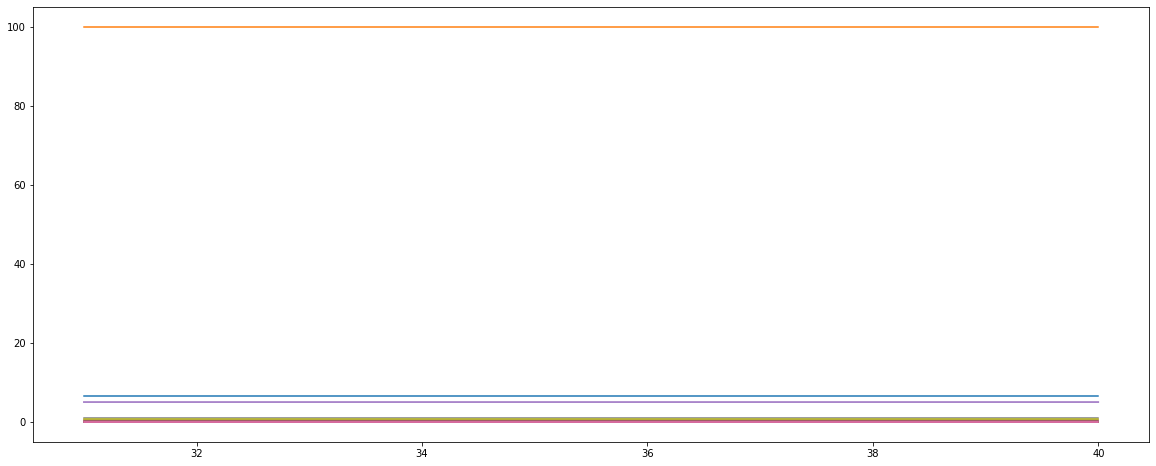

In [511]:
plt.figure(figsize=(20,8))
plt.plot(dat.tail(10))
plt.show()